In [449]:
import glob
import json
import math
import numpy as np
import tensorflow as tf

from utils import champion2vec_loader

np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [404]:
files = glob.glob('./dat_challenger_only/*timeline*')

print(len(files))

7539


In [463]:
champions_array, champion_lanes_array, map_champions = champion2vec_loader.get_champion_sets_from_files(files[:2000])
print(len(champions_array), 'teams loaded')

0 of 2000
1000 of 2000
(4000, 5)
4000 teams loaded


In [466]:
# save teams

fout = 'champion_sets.npz'
champion2vec_loader.save_champion_set(fout, champions_array, champion_lanes_array, map_champions)

In [467]:
# load champions

fin = 'champion_sets.npz'
champions_array, champion_lanes_array, map_champions = champion2vec_loader.load_champion_set(fin)

In [477]:
# https://developer.riotgames.com/static-data.html#realms
# load static data on champions

champion_file = 'champion.json'

champion_ids, champion_names, champion_roles_array, all_roles_dict = champion2vec_loader.get_champion_static(champion_file)

In [485]:
all_roles_dict

{'Assassin': 0,
 'Fighter': 1,
 'Mage': 2,
 'Marksman': 3,
 'Support': 4,
 'Tank': 5}

In [468]:
num_unique_champions = vocabulary_size = len(list(map_champions.keys()))

print(vocabulary_size, 'unique champions')

139 unique champions


In [469]:
champion_lanes_array

array([['BOTTOM', 'MIDDLE', 'TOP', 'BOTTOM', 'JUNGLE'],
       ['MIDDLE', 'BOTTOM', 'BOTTOM', 'TOP', 'JUNGLE'],
       ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'BOTTOM'],
       ...,
       ['JUNGLE', 'JUNGLE', 'BOTTOM', 'TOP', 'BOTTOM'],
       ['TOP', 'BOTTOM', 'JUNGLE', 'MIDDLE', 'BOTTOM'],
       ['JUNGLE', 'BOTTOM', 'MIDDLE', 'TOP', 'BOTTOM']], dtype='<U6')

In [475]:
unique_ids, counts = np.unique(champions_array, return_counts=True)

frequencies = counts / num_matches

frequencies = frequencies / np.max(frequencies) * 100# rescale to the max

frequencies

array([ 12.18130312,   5.09915014,  26.48725212,  23.93767705,
        13.88101983,   9.49008499,  12.46458924,  31.16147309,
         8.07365439,   3.68271955,   7.08215297,  43.48441926,
        43.76770538,  17.1388102 ,  19.68838527,  13.73937677,
        22.3796034 , 100.        ,  28.04532578,  18.55524079,
         7.93201133,   6.09065156,   5.38243626,  52.83286119,
        23.22946176,   7.08215297,  11.1898017 ,  19.83002833,
        28.61189802,   5.09915014,   9.20679887,   2.69121813,
         5.52407932,  11.75637394,   8.92351275,   4.67422096,
        11.61473088,  16.57223796,   9.91501416,  74.22096317,
        50.84985836,  18.55524079,  27.6203966 ,  27.05382436,
        14.87252125,   8.92351275,  15.29745042,  32.71954674,
        22.66288952,  16.99716714,  15.7223796 ,   2.69121813,
        14.02266289,  11.33144476,  47.73371105,   7.50708215,
        24.78753541,   4.81586402,  23.22946176,  35.97733711,
        45.04249292,   5.66572238,   7.50708215,  23.65

In [368]:
embedding_size = batch_size = 20
context_size = 4
num_sampled = 16

valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

# re-index

champions_array = np.vectorize(map_champions.get)(champions_array)
champions_array

139 unique champions


array([[137,  33,  16, 135, 100],
       [  7,  81,  11, 102,  18],
       [111,  85,  78,  17,  15],
       ...,
       [ 23,  56,  48,  13,  98],
       [ 23,  17,  66,  84,  92],
       [  8,  47,  50,  53,  39]])

In [361]:
char_lanes = {}
lanes = ['TOP', 'MIDDLE', 'BOTTOM', 'JUNGLE', 'NONE']

n = len(champions_array)
for i in range(n):
    for j in range(5):
        #cur_character = map_champions[champions_array[i,j]]
        cur_character = champions_array[i,j]
        cur_lane = champion_lanes_array[i,j]
        if cur_character not in char_lanes:
            char_lanes[cur_character] = {}
            char_lanes[cur_character][cur_lane] = 1
            #char_lanes[cur_character]['TOTAL'] = 1
        else:
            if cur_lane not in char_lanes[cur_character]:
                char_lanes[cur_character][cur_lane] = 1
            else:
                char_lanes[cur_character][cur_lane] += 1
            #char_lanes[cur_character]['TOTAL'] += 1
            
# https://stackoverflow.com/questions/268272/getting-key-with-maximum-value-in-dictionary
import operator

# max(stats.items(), key=operator.itemgetter(1))[0]

char_main_lane = {}

for key in char_lanes.keys():
    char_main_lane[key] = max(char_lanes[key].items(), key=operator.itemgetter(1))[0]

In [362]:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

nce_weights = tf.Variable(
  tf.truncated_normal([vocabulary_size, embedding_size],
                      stddev=1.0 / math.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))


graph = tf.Graph()

with graph.as_default():
    # Input data
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size, context_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
        # take mean of embeddings of context words for context embedding
        embed_context = tf.reduce_mean(embed, 1)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
        tf.nn.nce_loss(nce_weights, nce_biases, train_labels,embed_context, 
                       num_sampled, vocabulary_size)) # had to swap labels and context

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.initialize_all_variables()

In [363]:
def generate_batch(batch_size, cur_window, cur_center, counter = 0):
    return champions_array[counter:counter+batch_size,cur_window], champions_array[counter:counter+batch_size,cur_center].reshape((batch_size,1))

# train test split
split = int(len(champions_array)*0.9)
heroes_train = champions_array[:split]
heroes_test = champions_array[split:]

# Step 5: Begin training.
num_steps = 10000

counter = 0
cur_center = 1
cur_center = cur_center % 5
cur_window = list(range(5))
cur_window.remove(cur_center)

#with tf.Session(graph=graph) as session:
with tf.Session(graph=graph) as session:
# We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in range(num_steps):
        if counter > split - batch_size:
            counter = 0
            cur_center += 1
            cur_center = cur_center % 5
            cur_window = list(range(5))
            cur_window.remove(cur_center)
        batch_inputs, batch_labels = generate_batch(
            batch_size, cur_window, cur_center, counter)
        counter += batch_size
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  31.673070907592773
Average loss at step  2000 :  3.414161385118961
Average loss at step  4000 :  2.693637732207775
Average loss at step  6000 :  2.606346713125706
Average loss at step  8000 :  2.5812453834414484


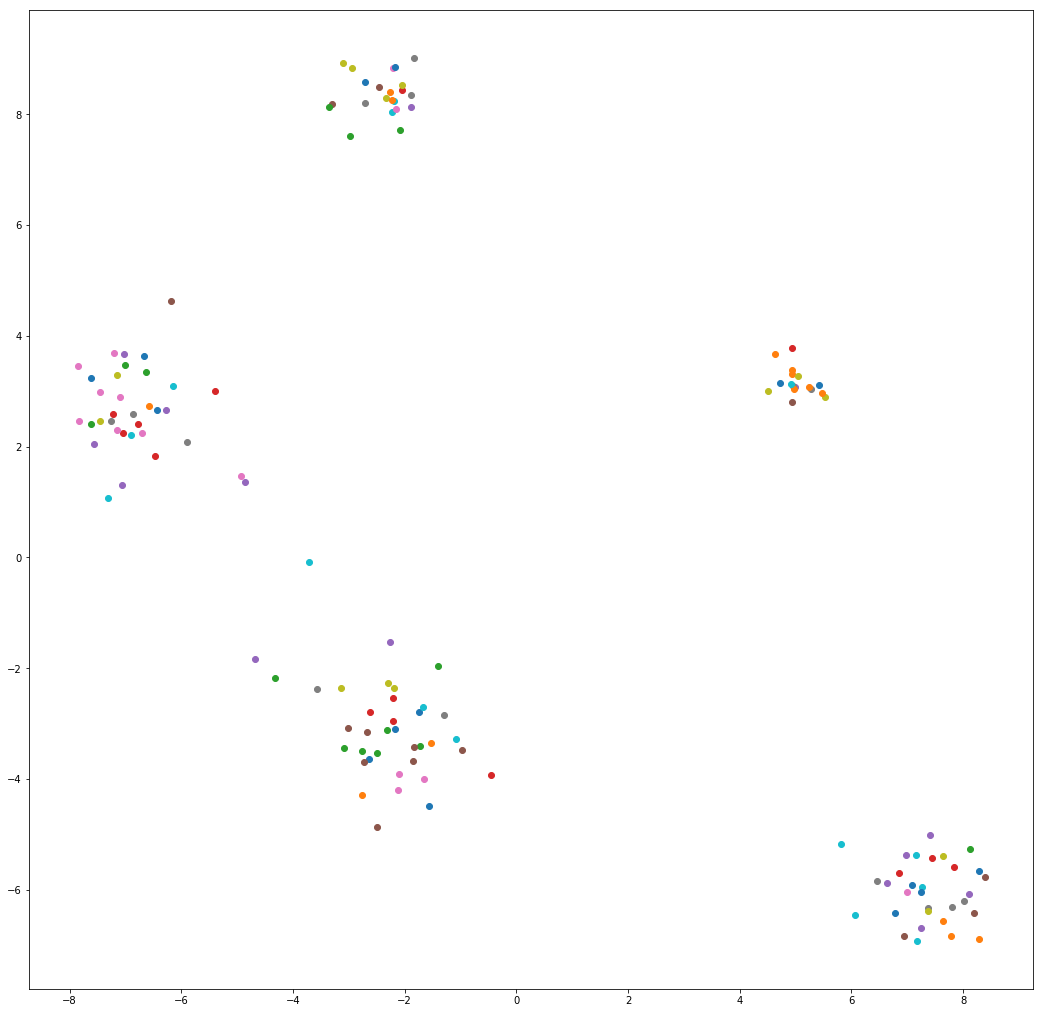

In [364]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
low_dim_embs = tsne.fit_transform(final_embeddings)
plt.figure(figsize=(18, 18))  # in inches
for i in range(vocabulary_size):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)

In [400]:
champion_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  48,  50,  51,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  67,  68,  69,  72,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  89,
        90,  91,  92,  96,  98,  99, 101, 102, 103, 104, 105, 106, 107,
       110, 111, 112, 113, 114, 115, 117, 119, 120, 121, 122, 126, 127,
       131, 133, 134, 136, 141, 142, 143, 145, 150, 154, 157, 161, 163,
       164, 201, 202, 203, 222, 223, 236, 238, 240, 245, 254, 266, 267,
       268, 412, 420, 421, 427, 429, 432, 497, 498, 516, 555])

In [343]:
def find_champion(champion_to_find, champion_names):
    return np.where(champion_names == champion_to_find)[0][0]

index = find_champion('Shen', champion_names)
shen_appears = len(np.where(champions_array == index)[0]) / num_matches
print(shen_appears)
champion_ids[index]

0.03006739243131156


98

In [49]:
all_roles_dict

{'Assassin': 0,
 'Fighter': 1,
 'Mage': 2,
 'Marksman': 3,
 'Support': 4,
 'Tank': 5}

In [504]:
fout = 'embeddings.npz'

np.savez(fout,
         champion_ids = champion_ids,
         champion_names = champion_names,
         champion_roles_array = champion_roles_array,
         champion_embeddings = final_embeddings,
         all_roles_dict = all_roles_dict)

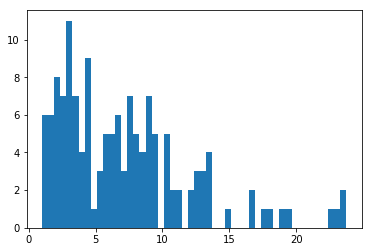

In [308]:
plt.hist(frequencies,bins=50);

Marksman
Marksman
26


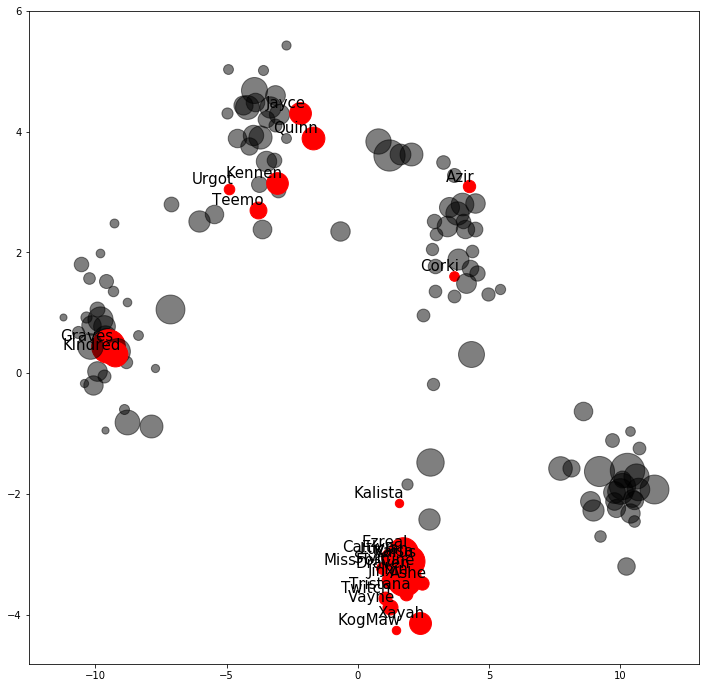

In [309]:
cur_role = 3
secondary_role = 3

print(all_roles[cur_role])
print(all_roles[secondary_role])

plt.figure(figsize=(12, 12))  # in inches
counter = 0
for i in range(vocabulary_size):
    x, y = low_dim_embs[i, :]
    if champion_roles_array[i, cur_role] == 1 and champion_roles_array[i, secondary_role] == 1:
        c = 'red'
        counter += 1
        plt.scatter(x, y, c=c, s = frequencies[i]*50)
        plt.annotate(
            s=champion_names[i],
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom',
            fontsize=15)
    else:
        c = 'black'
        plt.scatter(x, y, c=c, s = frequencies[i]*50, alpha=0.5)

print(counter)

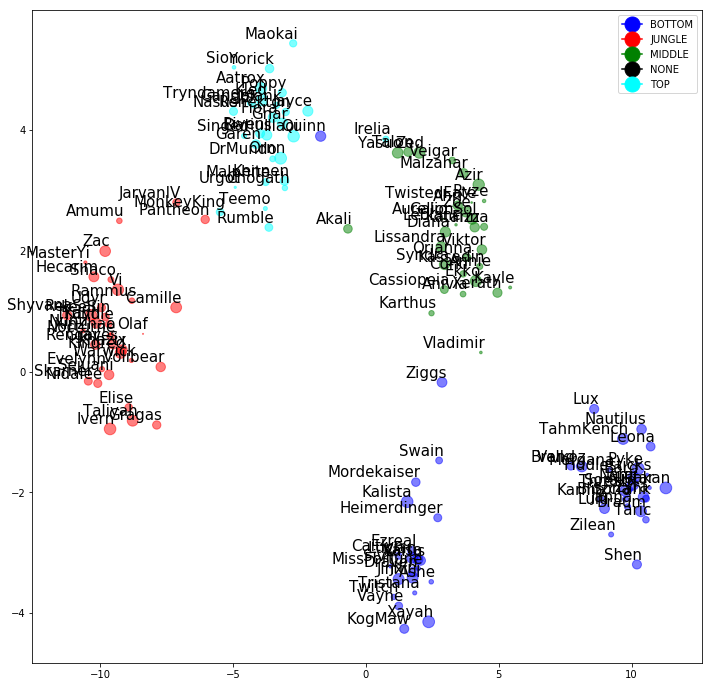

In [310]:
from matplotlib.lines import Line2D

# color by main lane

c = ['blue','red','green','black','cyan']

lanes_color = {
    'BOTTOM': c[0],
    'JUNGLE': c[1],
    'MIDDLE': c[2],
    'NONE'  : c[3],
    'TOP'   : c[4]
}

plt.figure(figsize=(12, 12))  # in inches

for i in range(vocabulary_size):
    x, y = low_dim_embs[i, :]
    cur_lane = char_main_lane[map_champions[champion_ids[i]]]
    #print(cur_lane, lanes_color[cur_lane])

    plt.scatter(x, y, c=lanes_color[cur_lane], s = [i]*100, alpha = 0.5)
    plt.annotate(
        s=champion_names[i],
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom',
        fontsize=15)

legend_elements = []
for key in lanes_color.keys():
    legend_elements.append(Line2D([0], [0], marker='o', c=lanes_color[key], label=key,
                          markerfacecolor=lanes_color[key], markersize=15))

ax = plt.gca()
ax.legend(handles=legend_elements, loc='upper right')

In [311]:
index = np.where(champion_names == 'Shen')[0][0]

low_dim_embs[index]

array([10.203801 , -3.1924546], dtype=float32)

In [184]:
np.vectorize(map_champions.get)(champion_ids)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140])

In [350]:
team_embeddings = []
for i, x in enumerate(champions_array):
    team_embeddings.append(np.sum(final_embeddings[x,:],axis=0))
    
team_embeddings = np.array(team_embeddings)

In [458]:
final_embeddings.shape

(141, 8)

In [318]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(final_embeddings)

In [351]:
embeddings_2d_team = pca.transform(team_embeddings)

Tank
Tank
41


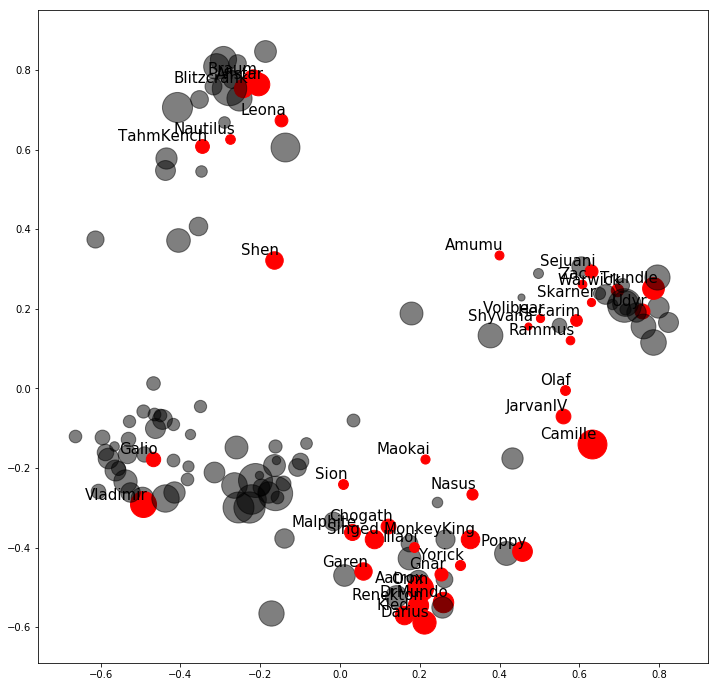

In [323]:
cur_role = 5
secondary_role = 5

print(all_roles[cur_role])
print(all_roles[secondary_role])

plt.figure(figsize=(12, 12))  # in inches
counter = 0
for i in range(vocabulary_size):
    x, y = embeddings_2d[i, :]
    if champion_roles_array[i, cur_role] == 1 and champion_roles_array[i, secondary_role] == 1:
        c = 'red'
        counter += 1
        plt.scatter(x, y, c=c, s = frequencies[i]*50)
        plt.annotate(
            s=champion_names[i],
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom',
            fontsize=15)
    else:
        c = 'black'
        plt.scatter(x, y, c=c, s = frequencies[i]*50, alpha=0.5)

print(counter)

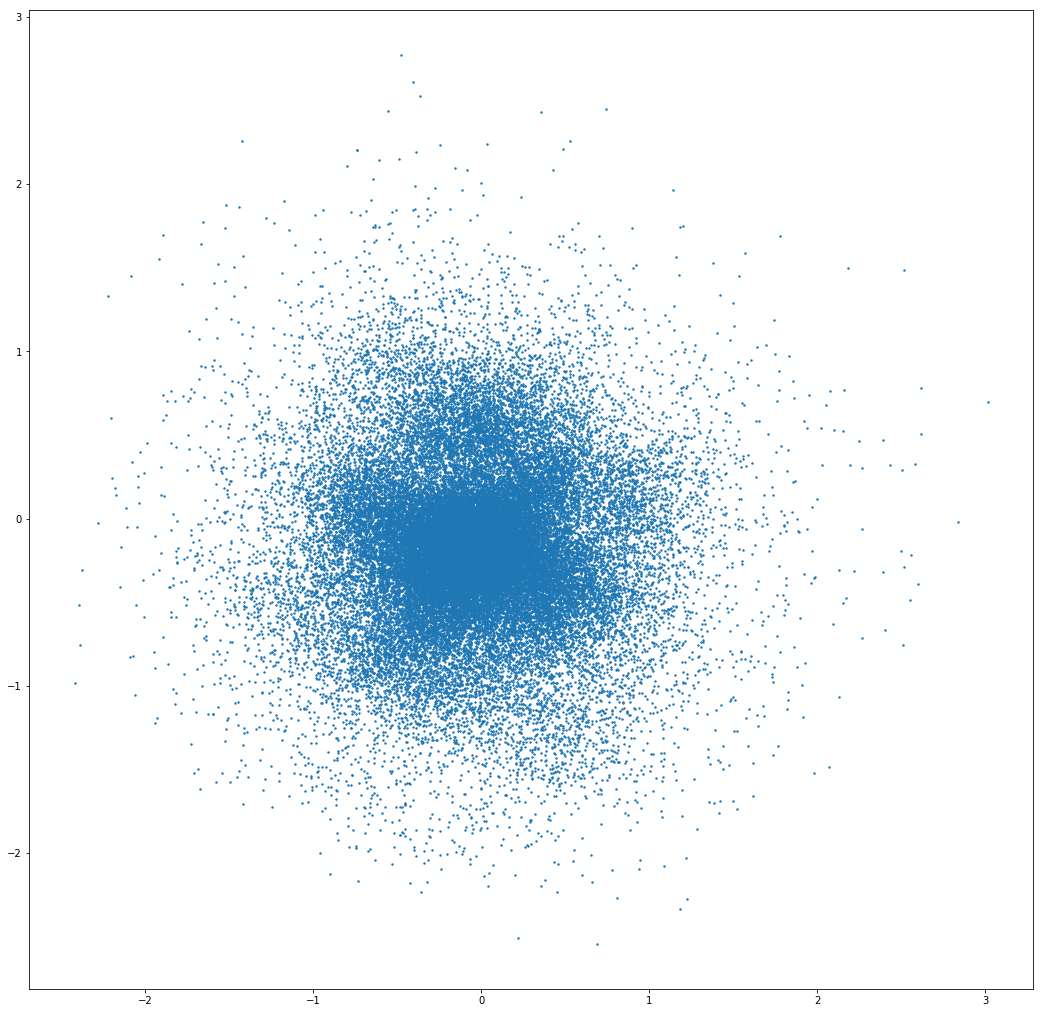

In [352]:
plt.figure(figsize=(18, 18))  # in inches

plt.scatter(embeddings_2d_team[:,0],embeddings_2d_team[:,1],s=2)

In [ ]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
low_dim_embs = tsne.fit_transform(final_embeddings)
plt.figure(figsize=(18, 18))  # in inches
for i in range(vocabulary_size):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)

In [69]:
sorted_ix = np.argsort(champion_ids)

In [70]:
champion_ids = np.array(champion_ids)[sorted_ix]
champion_names = np.array(champion_names)[sorted_ix]

In [71]:
for i,champ_id in enumerate(champion_ids):
    print(i, champ_id, champion_names[i])

In [52]:
from riotwatcher import RiotWatcher
api_key = 'RGAPI-9c654a3e-f083-4652-b043-3856c3bd4bd4'

watcher = RiotWatcher(api_key)

my_region = 'na1'

In [53]:
request = watcher.champion.all(my_region)

In [61]:
current_champion_id = request['champions'][0]['id']

In [63]:
champion_id_request = watcher.champion.by_id(my_region, current_champion_id)

In [64]:
champion_id_request

{'id': 266,
 'active': True,
 'botEnabled': False,
 'freeToPlay': False,
 'botMmEnabled': False,
 'rankedPlayEnabled': True}

In [506]:
np.unique(range(5))

0